Connected to .venv (Python 3.13.2)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("../datasets/autos.csv")

In [2]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [3]:
#  Fit scikit-learn's PCA estimator and create the principal component
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [4]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


### PC 分析
- PC1 在 engine_size, horsepower, curb_weight 權重較重，而 highway_mpg 為負，這表示 PC1 代表大馬力，大車體但耗油的車型與小型、經濟型但油耗較好的車輛之間的比較，所以可以稱之為“豪華/經濟”軸。
- PC2 偏重 highway_mpg, engine_size, 而 horsepower, curb_weight 權重較輕，這表示 PC2 代表高里程，大氣缸的長途車型。
- PC3 特別重視 horsepower，其他參數權重都低，代表跑車型的車輛。跑車/旅行車 軸
- PC4 engine_size 權重很高，但是其他參數的權重都是負值，代表大排氣量的車型。

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

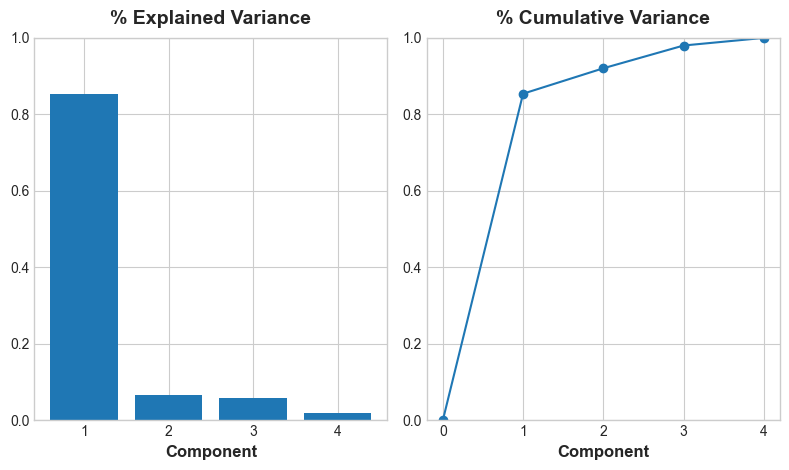

In [5]:
# Look at explained variance
plot_variance(pca)

## 解釋變異數圖 (Explained Variance Plot)
這兩張圖顯示了每個主成分對總變異數的貢獻。

### 左圖：「% Explained Variance (解釋變異數百分比)」
- 這是一個長條圖 (bar chart)，顯示了每個獨立的主成分所解釋的總變異數的比例。
- PC1 (Component 1) 的長條最高，表明它解釋了絕大部分的資料變異數。根據圖表，大約在 85% 左右。
- PC2 (Component 2) 其次，解釋了較小的比例。
- PC3 和 PC4 解釋的變異數比例非常小。
- **意義：這告訴我們，資料中絕大部分的差異（變異）可以透過 PC1 來捕捉。這證實了「Luxury/Economy axis」是這組特徵中最主要的變異方向。**

### 右圖：「% Cumulative Variance (累積變異數百分比)」
這是一個折線圖 (line plot)，顯示了累積解釋變異數的百分比。每個點代表了從第一個主成分到當前主成分所解釋的總變異數的累積和。
- 點 1：PC1 獨自解釋的變異數（與左圖 PC1 相同，約 85%）。
- 點 2：PC1 + PC2 累積解釋的變異數。
- 點 3：PC1 + PC2 + PC3 累積解釋的變異數。
- 點 4：PC1 + PC2 + PC3 + PC4 累積解釋的變異數（達到 1.0，即 100%，因為這裡只有 4 個原始特徵，所以會有 4 個主成分解釋所有變異）。
- **意義：這張圖幫助我們決定要保留多少個主成分以進行降維。如果我們想要保留 95% 的總變異數，我們可以看哪一點達到或超過這個閾值。從圖中看，僅僅 PC1 就已經解釋了大部分變異，保留 PC1 和 PC2 可能就足以捕捉絕大部分的信息了。**

In [6]:
# The MI scores of the components
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.013395
PC2    0.378913
PC3    0.307071
PC4    0.204299
Name: MI Scores, dtype: float64

第三個主成分 (PC3) 顯示了馬力和整備品質之間的對比——看起來就像是跑車和旅行車的對比。對照車商和車型確認看看

In [7]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
print(df.loc[idx, cols])

              make   body_style  horsepower  curb_weight
118        porsche      hardtop         207         2756
117        porsche      hardtop         207         2756
119        porsche  convertible         207         2800
45          jaguar        sedan         262         3950
96          nissan    hatchback         200         3139
..             ...          ...         ...          ...
59   mercedes-benz        wagon         123         3750
61   mercedes-benz        sedan         123         3770
101         peugot        wagon          95         3430
105         peugot        wagon          95         3485
143         toyota        wagon          62         3110

[193 rows x 4 columns]


為了表達這種對比，我們創造一個新的比率特徵：

<Axes: xlabel='sports_or_wagon', ylabel='price'>

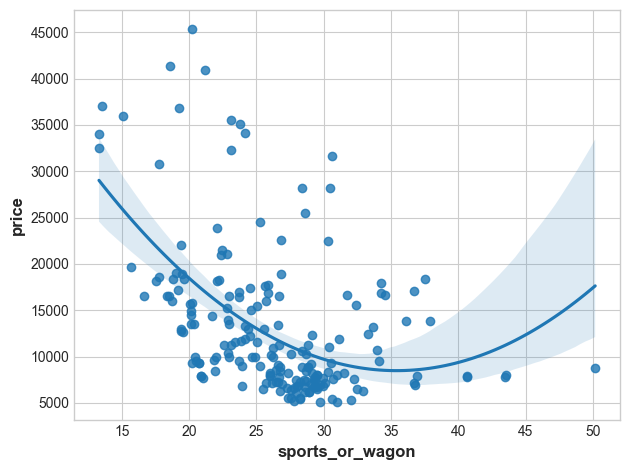

In [8]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2)

看看 PC3 與價格的關係

<Axes: xlabel='PC3', ylabel='price'>

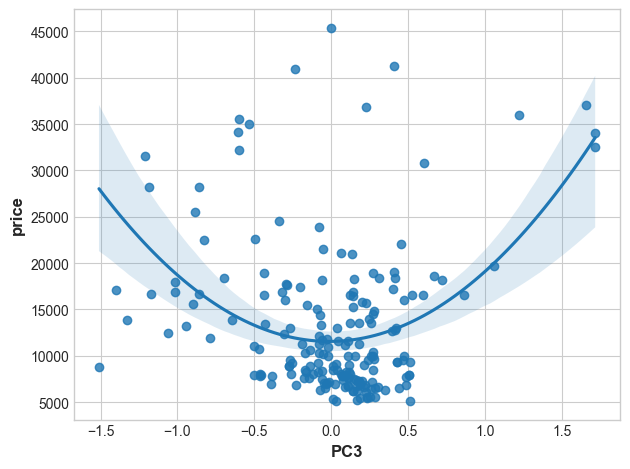

In [10]:
df1 = pd.concat([X_pca, y], axis=1)
sns.regplot(x="PC3", y='price', data=df1, order=2)